# HOMUS LeNet 5

Trains a simple LeNet-5 (http://yann.lecun.com/exdb/lenet/) adapted to the HOMUS dataset using Keras Software (http://keras.io/)

LeNet-5 demo example http://eblearn.sourceforge.net/beginner_tutorial2_train.html

This example executed with $30 \times 30$ reescaled images and $50$ epochs obtains an accuracy close to $70\%$.

## Install the following Python packages to run this notebook

`sudo apt-get install python python-dev libhdf5-serial-dev hdf5-tools python-pip`

`pip install pip -U`

`pip install keras tensorflow pillow h5py sklearn`

`pip install jupyter`

`pip install matplotlib`

## Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import backend as K

Using TensorFlow backend.


## Define global constants

Lets start with $5$ epochs to test learning network parameters

In [4]:
batch_size = 64
nb_classes = 32
epochs = 5

# HOMUS contains images of 40 x 40 pixels
# input image dimensions for train 
img_rows, img_cols = 30, 30

# Set image channels order
K.set_image_data_format('channels_last')

## Load image database HOMUS

In [6]:
#
# Load data from data/HOMUS/train_0, data/HOMUS/train_1,...,data/HOMUS_31 folders from HOMUS images
#
def load_data():
    image_list = []
    class_list = []
    for current_class_number in range(0,nb_classes):    # Number of class
        for filename in glob.glob('./data/HOMUS/train_{}/*.jpg'.format(current_class_number)):
            im = load_img(filename, grayscale=True, target_size=[img_rows, img_cols])  # this is a PIL image
            image_list.append(np.asarray(im).astype('float32')/255)
            class_list.append(current_class_number)

    n = len(image_list)    # Total examples
    
    # Format train set with one channel at last position
    X = np.asarray(image_list).reshape(n,img_rows,img_cols,1)
    input_shape = (img_rows, img_cols, 1)

    Y = np_utils.to_categorical(np.asarray(class_list), nb_classes)
    
    # Shuffle (X,Y)
    randomize = np.arange(len(Y))
    np.random.shuffle(randomize)
    X, Y = X[randomize], Y[randomize]

    n_partition = int(n*0.9)    # Train 90% and Test 10%

    X_train = X[:n_partition]
    Y_train = Y[:n_partition]
    
    X_test  = X[n_partition:]
    Y_test  = Y[n_partition:]
    
    return X_train, Y_train, X_test, Y_test, input_shape


## Plot image of symbols

In [5]:
def plot_symbols(X,Y,n):
    n = 15
    index = np.random.randint(len(X), size=n)
    plt.figure(figsize=(n, 2))
    for i in np.arange(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[index[i]].reshape(img_rows, img_cols))
        plt.gray()
        ax.set_title('{}-{}'.format(Y[i].argmax(),index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Build LeNet5 structure

In [7]:
#
# Build an ANN structure
#
def cnn_model(input_shape):
    #
    # Neural Network Structure
    #
    
    model = Sequential()
    
    model.add(Conv2D(6, (6, 6), padding='valid', input_shape = input_shape))
    model.add(Activation("sigmoid"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, (5, 5), padding='valid'))
    model.add(Activation("sigmoid"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(12, (1,1), padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("sigmoid"))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    return model

## Start to run the program

### Load data

In [8]:
##################################################################################
# Main program

# the data split between train and test sets
X_train, Y_train, X_test, Y_test, input_shape = load_data()

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(img_rows,'x', img_cols, 'image size')
print(input_shape,'input_shape')
print(epochs,'epochs')

12312 train samples
1368 test samples
30 x 30 image size
(30, 30, 1) input_shape
5 epochs


### Let to see same examples of HOMUS database

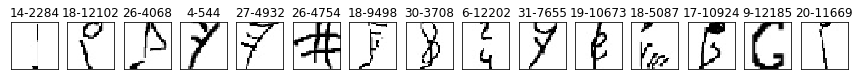

In [8]:
plot_symbols(X_train, Y_train, 15)

### Model and optinizers

Test optimizer parameter with `sgd` or `adadelta` values in order to check the final precision achieved.

In [9]:
model = cnn_model(input_shape)
print(model.summary())

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test, Y_test), callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 6)         222       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 16)          0         
__________

### Testing accuracy result

In [10]:
#
# Results
#
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:{:.2f} accuracy: {:.2f}%'.format(loss,acc*100))

Test score:3.43 accuracy: 5.70%
